## Setup (rodar antes de tudo)

In [52]:
# For reading stock data from yahoo
import yfinance as yf
import pandas as pd
import datetime as dt
import time
# For time stamps
from datetime import datetime
def download_1():
    # The tech stocks we'll use for this analysis
    tech_list = ['AAPL',]

    for stock in tech_list:
        print(stock)
        globals()[stock] = yf.download(stock, end="2024-01-01")

    company_list = [globals()[stock] for stock in tech_list]

    return company_list

def download_2():
    # For reading stock data from yahoo
    # The tech stocks we'll use for this analysis
    tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN','TSLA','NVDA','META','AMD','BABA','INTC','PYPL','EA']

    # Set up End and Start times for data grab
    #end = datetime.now()
    #start = datetime(end.year - 5, end.month, end.day)

    for stock in tech_list:
        print(stock)
        globals()[stock] = yf.download(stock, start="2024-01-01")

    company_list = [globals()[stock] for stock in tech_list]
    company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON","TESLA","NVIDIA","META","AMD","ALIBABA","INTEL","PAYPAL","ELECTRONIC ARTS"]

    for company, com_name in zip(company_list, company_name):
        company["company_name"] = com_name
    
    return company_list

def download_3():
        # The tech stocks we'll use for this analysis
    tech_list = ['AAPL',]

    for stock in tech_list:
        print(stock)
        globals()[stock] = yf.download(stock, start="2024-01-01")

    company_list = [globals()[stock] for stock in tech_list]

    return company_list

In [53]:
import os
import pathlib
def dataset_1():
    df = download_1()
    df = pd.concat(df, axis=0)
    df.reset_index(inplace=True)
    column_order = [
    'Date','Close',
    ]

    df = df[column_order].dropna()
    print(df.info())
    df.set_index('Date', drop=True, inplace=True)

    print(df.drop_duplicates().head())

    current_file_path = pathlib.Path().resolve()
    print(f"Current file path: {current_file_path}")

    # Save the DataFrame to a CSV file in the same directory
    stocks_path = current_file_path / 'data/train_data.csv'
    df.to_csv(stocks_path)

def dataset_2():
    #################################################################
    # TRATAMENTO DOS DADOS BAIXADOS E SALVAMENTO DOS DADOS TRATADOS #
    #################################################################

    import pandas as pd
    company_list = download_2()

    close = 'Adj Close'

    df = pd.concat(company_list, axis=0)
    df.reset_index(inplace=True)
    df.sort_values(by=['company_name','Date'])
    df['Will Increase'] = df.groupby('company_name')[close].shift(-1) > df.groupby('company_name')[close].shift(0)
    df['close_variation'] = df.groupby('company_name')[close].shift(0) - df.groupby('company_name')[close].shift(1)
    df['close_variation%'] = df.groupby('company_name')[close].shift(0) / df.groupby('company_name')[close].shift(1)

    def calculate_days_since(df):
        last_increase = 0
        last_decrease = 0
        days_since_increase = []
        days_since_decrease = []
        for will_increase in df['Will Increase']:
            days_since_increase.append(last_increase)
            days_since_decrease.append(last_decrease)
            if will_increase:
                last_increase = 0
                last_decrease += 1
            else:
                last_increase += 1
                last_decrease = 0
        return days_since_increase, days_since_decrease


    for company, group in df.groupby('company_name'):
        days_since_increase, days_since_decrease = calculate_days_since(group)
        df.loc[group.index, 'days_since_last_increase'] = days_since_increase
        df.loc[group.index, 'days_since_last_decrease'] = days_since_decrease

    if 'Date' in df.columns:
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['Day of the Week'] = df['Date'].dt.dayofweek

    column_order = [
        'Date','Month','Day', 'Day of the Week', 'Open', 'High', 'Low', 'Close',
        'Adj Close', 'Volume', 'company_name', 'Will Increase', 'close_variation',
        'close_variation%', 'days_since_last_increase', 'days_since_last_decrease'
    ]

    df = df[column_order].dropna()
    print(df.info())
    #print(df.drop_duplicates().info())
    print(df.sort_values(by=['company_name',"Date"]).head(15))
    current_file_path = pathlib.Path().resolve()
    print(f"Current file path: {current_file_path}")

    # Save the DataFrame to a CSV file in the same directory
    stocks_path = current_file_path / 'data/train_data.csv'
    df.to_csv(stocks_path, index=False)


def dataset_3():
    df = download_3()
    df = pd.concat(df, axis=0)
    df.reset_index(inplace=True)
    column_order = [
    'Date','Close',
    ]

    df = df[column_order].dropna()
    print(df.info())
    df.set_index('Date', drop=True, inplace=True)

    print(df.drop_duplicates().head())

    current_file_path = pathlib.Path().resolve()
    print(f"Current file path: {current_file_path}")

    # Save the DataFrame to a CSV file in the same directory
    stocks_path = current_file_path / 'data/train_data.csv'
    df.to_csv(stocks_path)

In [54]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


def load_csv(filename):
    df = pd.read_csv(filename, index_col='Date', parse_dates=True)
    return df

def random_train_test_split(df, test_size=0.2, random_state=None):
    """
    Split the dataset into training and testing sets randomly.
    
    Args:
        df: A pandas DataFrame of the dataset.
        test_size: Proportion of the dataset to include in the test split.
        random_state: Controls the shuffling applied to the data before applying the split.
        
    Returns:
        train: Training set as a pandas DataFrame.
        test: Testing set as a pandas DataFrame.
    """
    train, test = train_test_split(df, test_size=test_size, random_state=random_state)
    return train, test

def prepare_data_1(df, lookback, test_size=0.2):
    """
    Split the dataset into training and testing sets, and transform them into prediction datasets.
    
    Args:
        df: A pandas DataFrame or numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
        test_size: Proportion of the dataset to include in the test split
    """
    # Split the dataset into training and testing sets
    train_size = int(len(df) * (1 - test_size))
    train, test = df[:train_size], df[train_size:]

    # Transform the training set into a prediction dataset
    X_train, y_train = [], []
    for i in range(len(train) - lookback):
        feature = train[i:i + lookback]
        target = train[i + 1:i + lookback + 1]
        X_train.append(feature)
        y_train.append(target)
    
    # Transform the testing set into a prediction dataset
    X_test, y_test = [], []
    for i in range(len(test) - lookback):
        feature = test[i:i + lookback]
        target = test[i + 1:i + lookback + 1]
        X_test.append(feature)
        y_test.append(target)
    
    # Convert to tensors and ensure the correct shape
    X_train = torch.tensor(np.array(X_train), dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(np.array(y_train), dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(np.array(X_test), dtype=torch.float32).unsqueeze(-1)
    y_test = torch.tensor(np.array(y_test), dtype=torch.float32).unsqueeze(-1)
    
    return X_train, y_train, X_test, y_test

In [55]:
#Modelos

import torch.nn as nn
 
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [56]:
def get_latest_run_path():
    base_path = pathlib.Path().resolve()
    base_path = base_path / 'runs'
    run_paths = [path for path in base_path.glob('train*') if path.is_dir()]
    
    if not run_paths:
        return None
    
    latest_run = max(run_paths, key=lambda x: int(x.name.replace('train', '')))
    return latest_run

def get_new_run_path():
    base_path = pathlib.Path().resolve()
    base_path = base_path / 'runs'
    latest_run_path = get_latest_run_path()
    
    if latest_run_path is None:
        new_run_number = 1
    else:
        latest_run_number = int(latest_run_path.name.replace('train', ''))
        new_run_number = latest_run_number + 1
    
    new_run_path = base_path / f'train{new_run_number}'
    os.makedirs(new_run_path, exist_ok=True)
    return new_run_path

## Treino

In [57]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import json
def pipeline_1():
    current_file_path = pathlib.Path().resolve()
    # Save the DataFrame to a CSV file in the same directory
    STOCKS_PATH = current_file_path / 'data/train_data.csv'
    CURRENT_MODEL_PATH = get_latest_run_path() / 'model.pth'

    #Download/tratamento dos dos dados
    dataset_1()

    #Transformação dos dados
    df = load_csv(STOCKS_PATH)
    df = df['Close']
    X_train, y_train, X_test, y_test = prepare_data_1(df, lookback=50, test_size=0.1)

    # Move tensors to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    #Definição do Modelo
    model = LSTMModel().to(device)
    model.load_state_dict(torch.load(CURRENT_MODEL_PATH))
    print(f"Loaded model from {CURRENT_MODEL_PATH}")
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=128,num_workers=4)

    #Treinamento
    n_epochs = 10
    train_rmse_list = []
    test_rmse_list = []
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        if epoch % 100 == 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
        train_rmse_list.append(train_rmse.item())
        test_rmse_list.append(test_rmse.item())

    NEW_MODEL_PATH = get_new_run_path() / 'model.pth'
    torch.save(model.state_dict(), NEW_MODEL_PATH)
    print(f"Model saved to {NEW_MODEL_PATH}")
    # Save the training metrics

    METRIC_PATH = get_latest_run_path() / 'training_metrics.json'
    with open(METRIC_PATH, 'w') as f:
        json.dump({'train_rmse': train_rmse_list, 'test_rmse': test_rmse_list}, f)
    print(f"Training metrics saved to {METRIC_PATH}")

pipeline_1()

[*********************100%%**********************]  1 of 1 completed

AAPL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10853 entries, 0 to 10852
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10853 non-null  datetime64[ns]
 1   Close   10853 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 169.7 KB
None
               Close
Date                
1980-12-12  0.128348
1980-12-15  0.121652
1980-12-16  0.112723
1980-12-17  0.115513
1980-12-18  0.118862
Current file path: D:\Github\Stocks-Machine-Learning\code3


Loaded model from D:\Github\Stocks-Machine-Learning\code3\runs\train1\model.pth
Epoch 1: train RMSE 1.0376, test RMSE 97.5427
Epoch 2: train RMSE 0.8304, test RMSE 95.8439
Epoch 3: train RMSE 0.6767, test RMSE 94.4643
Epoch 4: train RMSE 0.5715, test RMSE 93.3634
Epoch 5: train RMSE 0.4997, test RMSE 92.4597
Epoch 6: train RMSE 0.4520, test RMSE 91.7289
Epoch 7: train RMSE 0.4088, test RMSE 91.0788
Epoch 8: train RMSE 0.3856, test RMSE 90.5519
Epoch 9: train RMSE 0.3587, test RMSE 90.0611
Model saved to D:\Github\Stocks-Machine-Learning\code3\runs\train2\model.pth
Training metrics saved to D:\Github\Stocks-Machine-Learning\code3\runs\train2\training_metrics.json


## Teste

AAPL


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10853 entries, 0 to 10852
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10853 non-null  datetime64[ns]
 1   Close   10853 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 169.7 KB
None
               Close
Date                
1980-12-12  0.128348
1980-12-15  0.121652
1980-12-16  0.112723
1980-12-17  0.115513
1980-12-18  0.118862
Current file path: D:\Github\Stocks-Machine-Learning\code3


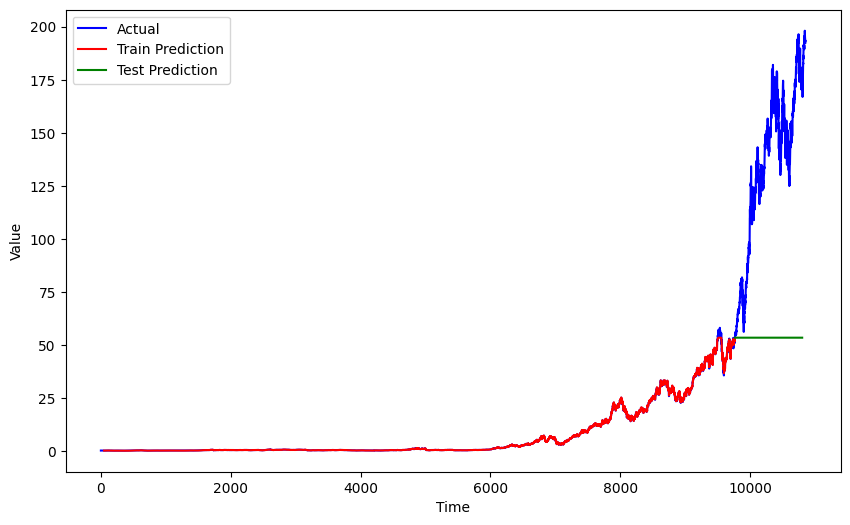

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def test_model(model_path, X_train, X_test, y_train, y_test, timeseries, lookback=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # shift train predictions for plotting
        train_plot = np.ones_like(timeseries) * np.nan
        y_pred_train = model(X_train)[:, -1, :]
        train_plot[lookback:len(X_train) + lookback] = y_pred_train.cpu().numpy().flatten()

        # shift test predictions for plotting
        test_plot = np.ones_like(timeseries) * np.nan
        y_pred_test = model(X_test)[:, -1, :]
        test_plot[len(X_train) + lookback:len(X_train) + lookback + len(X_test)] = y_pred_test.cpu().numpy().flatten()

        y_pred = model(X_test).cpu().numpy()
        y_test_np = y_test.cpu().numpy()
    '''    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
        mae = mean_absolute_error(y_test_np, y_pred)
        r2 = r2_score(y_test_np, y_pred)

    test_metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    TEST_METRIC_PATH = get_latest_run_path() / 'test_metrics.json'
    with open(TEST_METRIC_PATH, 'w') as f:
        json.dump(test_metrics, f)
    print(f"Test metrics saved to {TEST_METRIC_PATH}")'''

    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, c='b', label='Actual')
    plt.plot(train_plot, c='r', label='Train Prediction')
    plt.plot(test_plot, c='g', label='Test Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(get_latest_run_path() / 'model.png')
    plt.show()

current_file_path = pathlib.Path().resolve()
# Save the DataFrame to a CSV file in the same directory
STOCKS_PATH = current_file_path / 'data/train_data.csv'
CURRENT_MODEL_PATH = get_latest_run_path() / 'model.pth'

#Download/tratamento dos dos dados
dataset_1()

#Transformação dos dados
df = load_csv(STOCKS_PATH)
df = df['Close']
X_train, y_train, X_test, y_test = prepare_data_1(df, lookback=50, test_size=0.1)
# Run the training pipeline

# Pass the full timeseries data for plotting
timeseries = df.values

# Run the test model function
test_model(CURRENT_MODEL_PATH, X_train, X_test, y_train, y_test, timeseries)

